In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


EfficientNetB0

using the same code but features 6 by boruta

✅ Loaded 320 images


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ input_layer[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1286)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    164,736 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,227,748 (16.13 MB)

 Trainable params: 175,617 (686.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.4328 - mse: 1.4328
Epoch 1: val_loss improved from inf to 0.67047, saving model to /content/best_efficientnet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - loss: 1.4311 - mse: 1.4311 - val_loss: 0.6705 - val_mse: 0.6705 - learning_rate: 1.0000e-04
Epoch 2/100
111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8995 - mse: 0.8995
Epoch 2: val_loss improved from 0.67047 to 0.52299, saving model to /content/best_efficientnet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.8985 - mse: 0.8985 - val_loss: 0.5230 - val_mse: 0.5230 - learning_rate: 1.0000e-04
Epoch 3/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7482 - mse: 0.7482
Epoch 3: val_loss improved from 0.52299 to 0.44314, saving model to /content/best_efficientnet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7476 - mse: 0.7476 - val_loss: 0.4431 - val_mse: 0.4431 - learning_rate: 1.0000e-04
Epoch 4/100
112/113 ━━━

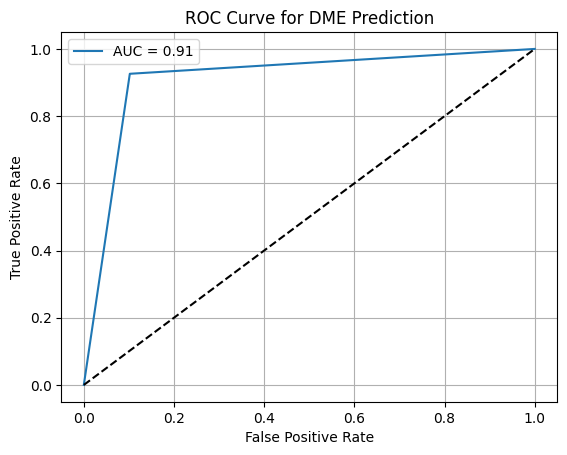

              precision    recall  f1-score   support

      No DME       0.92      0.90      0.91       500
         DME       0.90      0.93      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



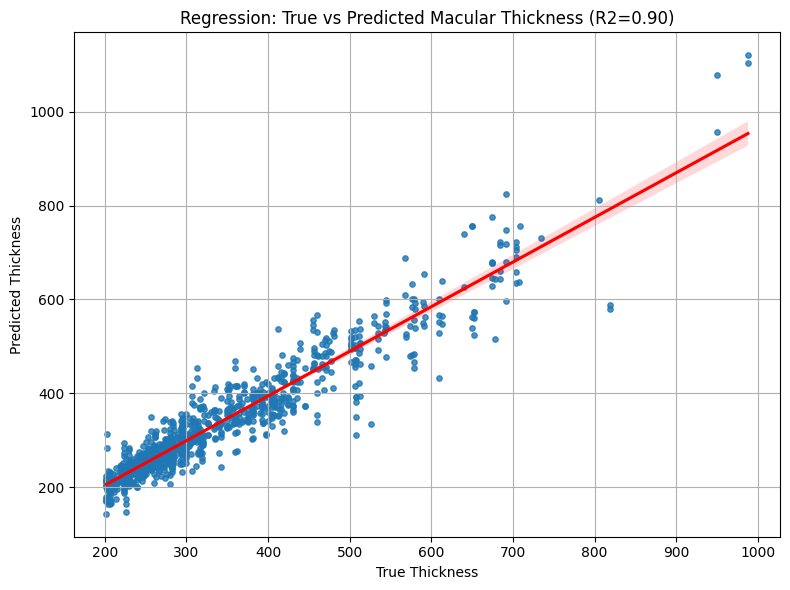

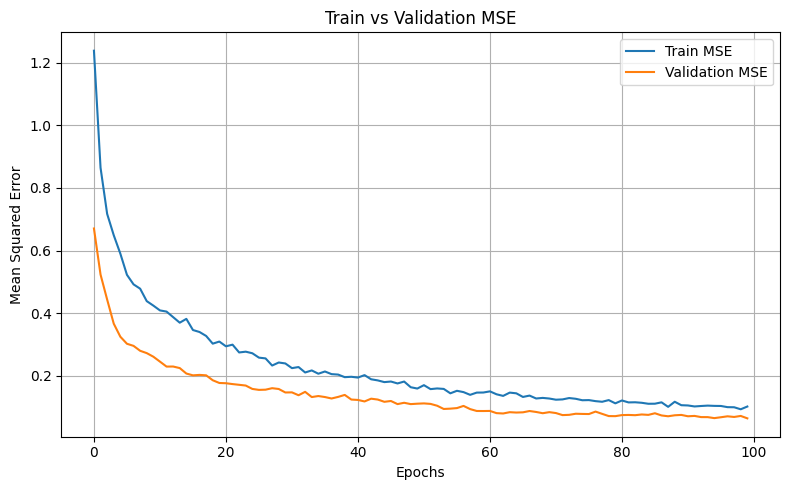

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# --- CONFIG ---
IMG_SIZE = 128
CSV_PATH = '/content/dme_patient_data.csv'
IMAGE_DIR = '/content/drive/MyDrive/DME FUNDUS IMAGES AIMS_SABITHA HOS'

# --- 1. Load CSV ---
df = pd.read_csv(CSV_PATH)
df['filename'] = df['Patient'].astype(str) + '.png'

def resolve_image_path(pid):
    for ext in ['.png', '.jpg', '.jpeg']:
        path = os.path.join(IMAGE_DIR, pid + ext)
        if os.path.isfile(path):
            return path
    return None

df['filepath'] = df['Patient'].apply(resolve_image_path)
df = df.dropna(subset=['filepath'])

# --- 2. Preprocess Images ---
def preprocess_image(path):
    try:
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Could not read image: {path}")
            return None
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = efficientnet_preprocess(img.astype(np.float32))
        return img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# --- DR Stage Mapping ---
dr_stage_map = {
    'No DR': 0,
    'Mild NPDR': 1,
    'Moderate NPDR': 2,
    'Severe NPDR': 3,
    'PDR': 4
}

images, tabular, labels, dme_labels = [], [], [], []

for _, row in df.iterrows():
    img = preprocess_image(row['filepath'])
    if img is not None:
        images.append(img)
        tabular.append([
            row['VA'],
            row['DiabetesDuration'],
            1 if row['Neovascularization'] == 'Yes' else 0,
            row['HbA1c'],
            dr_stage_map.get(row['Stage of DR'], -1),
            1 if row['Presence of DME'] == 'Yes' else 0
        ])
        labels.append(row['Macular Thickness'])
        dme_labels.append(1 if row['Macular Thickness'] >= 300 else 0)

X_img = np.array(images)
X_tab = np.array(tabular)
y_raw = np.array(labels)
y_dme = np.array(dme_labels)

print(f"✅ Loaded {len(X_img)} images")

# --- 3. Balanced Augmentation to 5000 ---
target_per_class = 2500

X_img_dme = X_img[y_dme == 1]
X_tab_dme = X_tab[y_dme == 1]
y_dme_dme = y_raw[y_dme == 1]

X_img_nodme = X_img[y_dme == 0]
X_tab_nodme = X_tab[y_dme == 0]
y_dme_nodme = y_raw[y_dme == 0]

def augment_to_target(X_img_cls, X_tab_cls, y_cls, target_count):
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )

    aug_imgs, aug_tabs, aug_labs, aug_dmes = list(X_img_cls), list(X_tab_cls), list(y_cls), [1 if y >= 300 else 0 for y in y_cls]
    gen = datagen.flow(X_img_cls, y_cls, batch_size=32, shuffle=True)
    count = len(X_img_cls)

    while count < target_count:
        x_batch, y_batch = next(gen)
        take = min(len(x_batch), target_count - count)
        aug_imgs.extend(x_batch[:take])
        aug_tabs.extend(X_tab_cls[:take])
        aug_labs.extend(y_batch[:take])
        aug_dmes.extend([1 if y >= 300 else 0 for y in y_batch[:take]])
        count += take

    return np.array(aug_imgs), np.array(aug_tabs), np.array(aug_labs), np.array(aug_dmes)

X_img_dme_aug, X_tab_dme_aug, y_dme_aug, y_dme_bin_aug = augment_to_target(X_img_dme, X_tab_dme, y_dme_dme, target_per_class)
X_img_nodme_aug, X_tab_nodme_aug, y_nodme_aug, y_nodme_bin_aug = augment_to_target(X_img_nodme, X_tab_nodme, y_dme_nodme, target_per_class)

X_img_aug = np.concatenate([X_img_dme_aug, X_img_nodme_aug], axis=0)
X_tab_aug = np.concatenate([X_tab_dme_aug, X_tab_nodme_aug], axis=0)
y_all = np.concatenate([y_dme_aug, y_nodme_aug], axis=0)
y_dme_all = np.concatenate([y_dme_bin_aug, y_nodme_bin_aug], axis=0)

# --- 4. Normalize ---
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_aug)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_all.reshape(-1, 1)).flatten()

# --- 5. Split ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_img_aug, y_dme_all):
    X_img_train, X_img_test = X_img_aug[train_idx], X_img_aug[test_idx]
    X_tab_train, X_tab_test = X_tab_scaled[train_idx], X_tab_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    y_dme_train, y_dme_test = y_dme_all[train_idx], y_dme_all[test_idx]

# --- 6. Build Model ---
def build_model(img_shape, tab_shape):
    img_input = Input(shape=img_shape)
    tab_input = Input(shape=tab_shape)

    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=img_shape)
    base.trainable = False

    x = base(img_input)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    merged = concatenate([x, tab_input])
    d1 = Dense(128, activation='relu')(merged)
    d2 = Dense(64, activation='relu')(d1)
    output = Dense(1)(d2)

    return Model(inputs=[img_input, tab_input], outputs=output)

model = build_model((IMG_SIZE, IMG_SIZE, 3), (X_tab.shape[1],))
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mse'])
model.summary()

# --- 7. Improved Early Stopping ---
checkpoint_path = '/content/best_efficientnet_model.keras'
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        min_delta=1e-4,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=10,
        factor=0.5,
        min_lr=1e-6,
        verbose=1
    )
]

# --- 8. Train ---
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --- 9. Evaluation ---
model.load_weights(checkpoint_path)
y_pred_scaled = model.predict([X_img_test, X_tab_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_true, y_pred)
print(f"Test R^2 Score: {r2:.4f}")

# --- 10. ROC for DME ---
dme_pred = (y_pred >= 300).astype(int)
unique_classes = np.unique(y_dme_test)
if len(unique_classes) < 2:
    print(f"⚠️ Only one class ({unique_classes[0]}) present in test labels. ROC and classification report are undefined.")
else:
    roc_auc = roc_auc_score(y_dme_test, dme_pred)
    fpr, tpr, _ = roc_curve(y_dme_test, dme_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for DME Prediction")
    plt.legend()
    plt.grid()
    plt.show()

    print(classification_report(y_dme_test, dme_pred, target_names=['No DME', 'DME']))

# --- 11. Scatter Plot ---
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), scatter_kws={'s': 15}, line_kws={'color': 'red'})
plt.xlabel('True Thickness')
plt.ylabel('Predicted Thickness')
plt.title(f'Regression: True vs Predicted Macular Thickness (R2={r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. MSE Plot ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


EfficientNetB0

✅ Loaded 320 images


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ input_layer_3[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1286)      │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    164,736 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,227,748 (16.13 MB)

 Trainable params: 175,617 (686.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.4940 - mse: 1.4940
Epoch 1: val_loss improved from inf to 0.67799, saving model to /content/best_efficientnet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - loss: 1.4918 - mse: 1.4918 - val_loss: 0.6780 - val_mse: 0.6780 - learning_rate: 1.0000e-04
Epoch 2/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8271 - mse: 0.8271
Epoch 2: val_loss improved from 0.67799 to 0.55857, saving model to /content/best_efficientnet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8278 - mse: 0.8278 - val_loss: 0.5586 - val_mse: 0.5586 - learning_rate: 1.0000e-04
Epoch 3/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6811 - mse: 0.6811
Epoch 3: val_loss improved from 0.55857 to 0.47408, saving model to /content/best_efficientnet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.6816 - mse: 0.6816 - val_loss: 0.4741 - val_mse: 0.4741 - learning_rate: 1.0000e-04
Epoch 4/100
113/113 ━━━

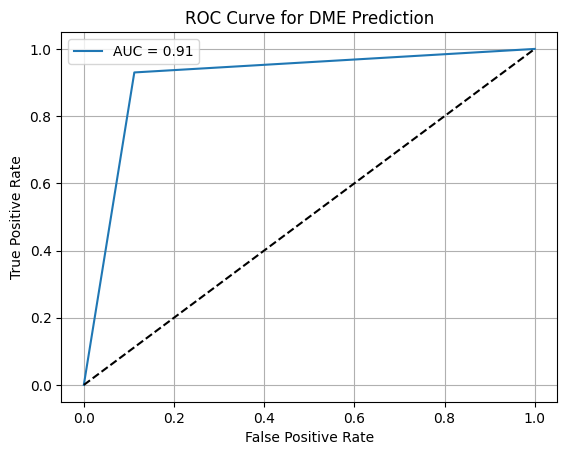

              precision    recall  f1-score   support

      No DME       0.93      0.89      0.91       500
         DME       0.89      0.93      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



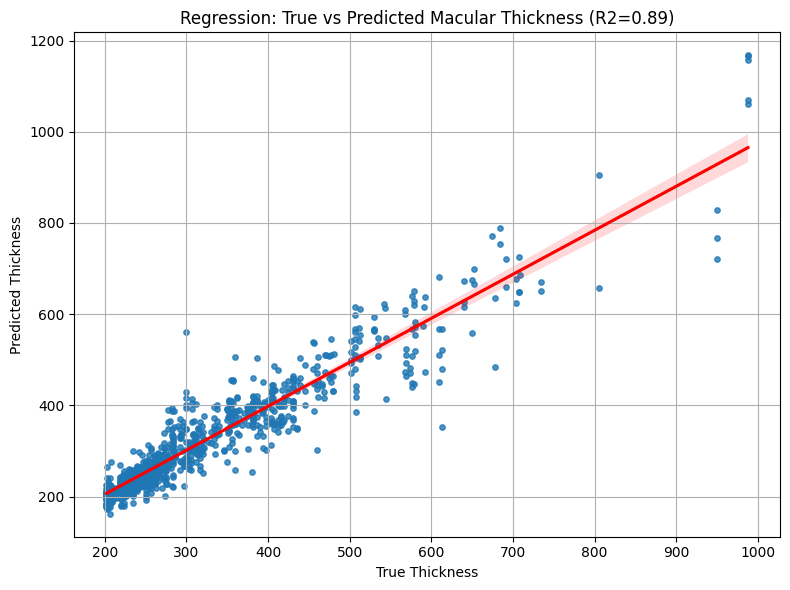

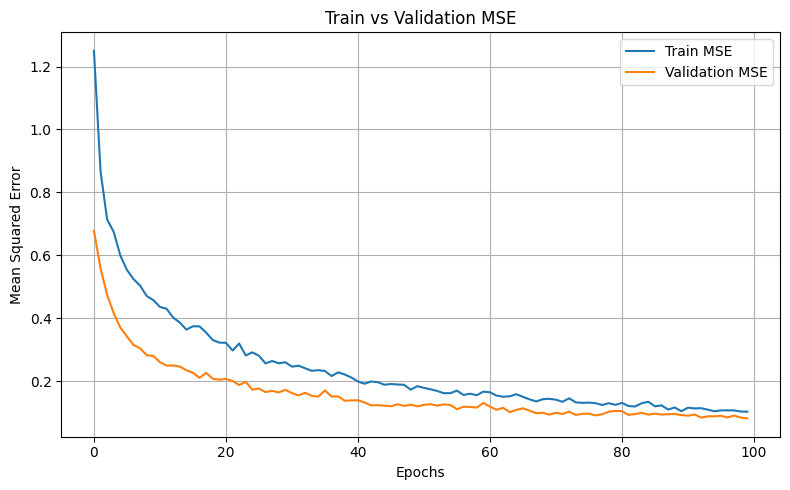

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# --- CONFIG ---
IMG_SIZE = 128
CSV_PATH = '/content/dme_patient_data.csv'
IMAGE_DIR = '/content/drive/MyDrive/DME FUNDUS IMAGES AIMS_SABITHA HOS'

# --- 1. Load CSV ---
df = pd.read_csv(CSV_PATH)
df['filename'] = df['Patient'].astype(str) + '.png'

def resolve_image_path(pid):
    for ext in ['.png', '.jpg', '.jpeg']:
        path = os.path.join(IMAGE_DIR, pid + ext)
        if os.path.isfile(path):
            return path
    return None

df['filepath'] = df['Patient'].apply(resolve_image_path)
df = df.dropna(subset=['filepath'])

# --- 2. Preprocess Images ---
def preprocess_image(path):
    try:
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Could not read image: {path}")
            return None
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = efficientnet_preprocess(img.astype(np.float32))
        return img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# --- DR Stage Mapping ---
dr_stage_map = {
    'No DR': 0,
    'Mild NPDR': 1,
    'Moderate NPDR': 2,
    'Severe NPDR': 3,
    'PDR': 4
}

images, tabular, labels, dme_labels = [], [], [], []

for _, row in df.iterrows():
    img = preprocess_image(row['filepath'])
    if img is not None:
        images.append(img)
        tabular.append([
            row['VA'],
            row['DiabetesDuration'],
            1 if row['Neovascularization'] == 'Yes' else 0,
            row['HbA1c'],
            dr_stage_map.get(row['Stage of DR'], -1),
            1 if row['Presence of DME'] == 'Yes' else 0
        ])
        labels.append(row['Macular Thickness'])
        dme_labels.append(1 if row['Macular Thickness'] >= 270 else 0)

X_img = np.array(images)
X_tab = np.array(tabular)
y_raw = np.array(labels)
y_dme = np.array(dme_labels)

print(f"✅ Loaded {len(X_img)} images")

# --- 3. Balanced Augmentation to 5000 ---
target_per_class = 2500

X_img_dme = X_img[y_dme == 1]
X_tab_dme = X_tab[y_dme == 1]
y_dme_dme = y_raw[y_dme == 1]

X_img_nodme = X_img[y_dme == 0]
X_tab_nodme = X_tab[y_dme == 0]
y_dme_nodme = y_raw[y_dme == 0]

def augment_to_target(X_img_cls, X_tab_cls, y_cls, target_count):
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )

    aug_imgs, aug_tabs, aug_labs, aug_dmes = list(X_img_cls), list(X_tab_cls), list(y_cls), [1 if y >= 270 else 0 for y in y_cls]
    gen = datagen.flow(X_img_cls, y_cls, batch_size=32, shuffle=True)
    count = len(X_img_cls)

    while count < target_count:
        x_batch, y_batch = next(gen)
        take = min(len(x_batch), target_count - count)
        aug_imgs.extend(x_batch[:take])
        aug_tabs.extend(X_tab_cls[:take])
        aug_labs.extend(y_batch[:take])
        aug_dmes.extend([1 if y >= 270 else 0 for y in y_batch[:take]])
        count += take

    return np.array(aug_imgs), np.array(aug_tabs), np.array(aug_labs), np.array(aug_dmes)

X_img_dme_aug, X_tab_dme_aug, y_dme_aug, y_dme_bin_aug = augment_to_target(X_img_dme, X_tab_dme, y_dme_dme, target_per_class)
X_img_nodme_aug, X_tab_nodme_aug, y_nodme_aug, y_nodme_bin_aug = augment_to_target(X_img_nodme, X_tab_nodme, y_dme_nodme, target_per_class)

X_img_aug = np.concatenate([X_img_dme_aug, X_img_nodme_aug], axis=0)
X_tab_aug = np.concatenate([X_tab_dme_aug, X_tab_nodme_aug], axis=0)
y_all = np.concatenate([y_dme_aug, y_nodme_aug], axis=0)
y_dme_all = np.concatenate([y_dme_bin_aug, y_nodme_bin_aug], axis=0)

# --- 4. Normalize ---
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_aug)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_all.reshape(-1, 1)).flatten()

# --- 5. Split ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_img_aug, y_dme_all):
    X_img_train, X_img_test = X_img_aug[train_idx], X_img_aug[test_idx]
    X_tab_train, X_tab_test = X_tab_scaled[train_idx], X_tab_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    y_dme_train, y_dme_test = y_dme_all[train_idx], y_dme_all[test_idx]

# --- 6. Build Model ---
def build_model(img_shape, tab_shape):
    img_input = Input(shape=img_shape)
    tab_input = Input(shape=tab_shape)

    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=img_shape)
    base.trainable = False

    x = base(img_input)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    merged = concatenate([x, tab_input])
    d1 = Dense(128, activation='relu')(merged)
    d2 = Dense(64, activation='relu')(d1)
    output = Dense(1)(d2)

    return Model(inputs=[img_input, tab_input], outputs=output)

model = build_model((IMG_SIZE, IMG_SIZE, 3), (X_tab.shape[1],))
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mse'])
model.summary()

# --- 7. Improved Early Stopping ---
checkpoint_path = '/content/best_efficientnet_model.keras'
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        min_delta=1e-4,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=10,
        factor=0.5,
        min_lr=1e-6,
        verbose=1
    )
]

# --- 8. Train ---
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --- 9. Evaluation ---
model.load_weights(checkpoint_path)
y_pred_scaled = model.predict([X_img_test, X_tab_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_true, y_pred)
print(f"Test R^2 Score: {r2:.4f}")

# --- 10. ROC for DME ---
dme_pred = (y_pred >= 270).astype(int)
unique_classes = np.unique(y_dme_test)
if len(unique_classes) < 2:
    print(f"⚠️ Only one class ({unique_classes[0]}) present in test labels. ROC and classification report are undefined.")
else:
    roc_auc = roc_auc_score(y_dme_test, dme_pred)
    fpr, tpr, _ = roc_curve(y_dme_test, dme_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for DME Prediction")
    plt.legend()
    plt.grid()
    plt.show()

    print(classification_report(y_dme_test, dme_pred, target_names=['No DME', 'DME']))

# --- 11. Scatter Plot ---
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), scatter_kws={'s': 15}, line_kws={'color': 'red'})
plt.xlabel('True Thickness')
plt.ylabel('Predicted Thickness')
plt.title(f'Regression: True vs Predicted Macular Thickness (R2={r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. MSE Plot ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ResNet

✅ Loaded 320 images


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ input_layer_6[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 2054)      │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    263,040 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,867,265 (91.05 MB)

 Trainable params: 275,457 (1.05 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.6133 - mse: 1.6133
Epoch 1: val_loss improved from inf to 0.63331, saving model to /content/best_fundusnet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - loss: 1.6110 - mse: 1.6110 - val_loss: 0.6333 - val_mse: 0.6333 - learning_rate: 1.0000e-04
Epoch 2/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8914 - mse: 0.8914
Epoch 2: val_loss improved from 0.63331 to 0.52463, saving model to /content/best_fundusnet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - loss: 0.8907 - mse: 0.8907 - val_loss: 0.5246 - val_mse: 0.5246 - learning_rate: 1.0000e-04
Epoch 3/100
111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7276 - mse: 0.7276
Epoch 3: val_loss improved from 0.52463 to 0.46422, saving model to /content/best_fundusnet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.7281 - mse: 0.7281 - val_loss: 0.4642 - val_mse: 0.4642 - learning_rate: 1.0000e-04
Epoch 4/100
112/113 ━━━━━━━━━━━━

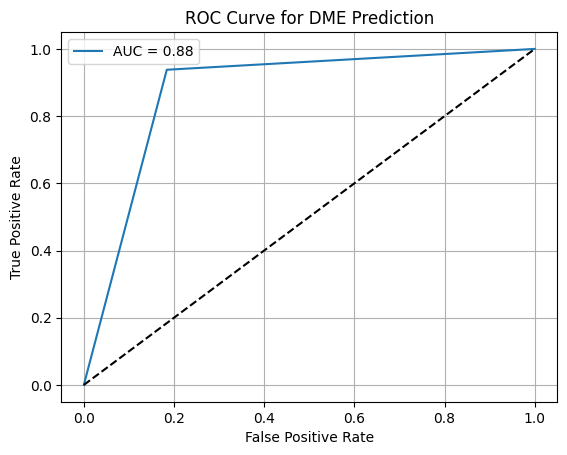

              precision    recall  f1-score   support

      No DME       0.93      0.82      0.87       500
         DME       0.84      0.94      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



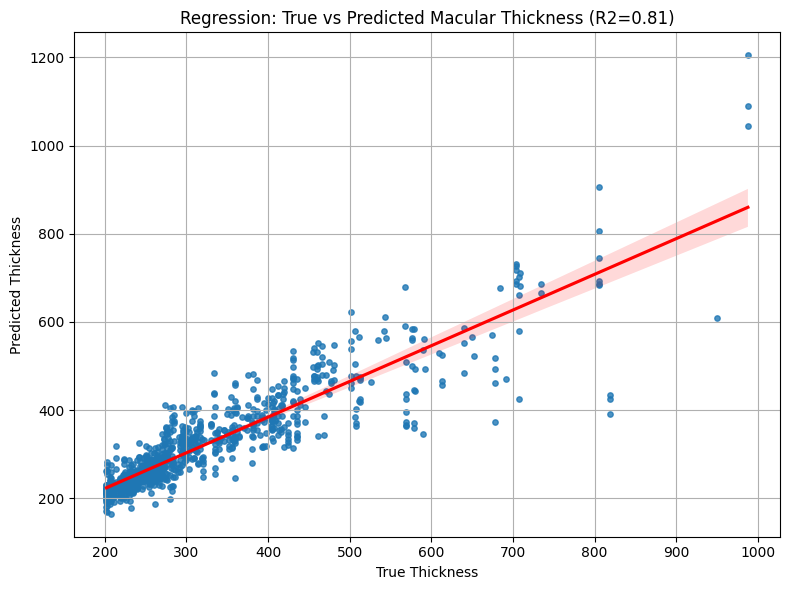

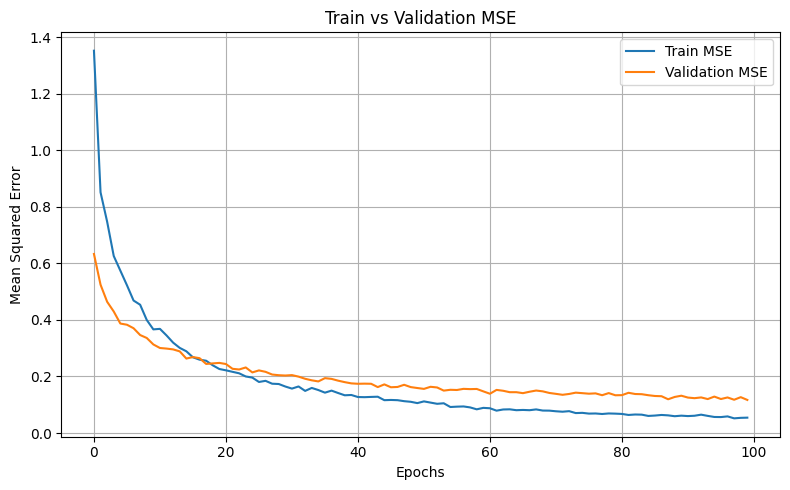

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

# --- CONFIG ---
IMG_SIZE = 128
CSV_PATH = '/content/dme_patient_data.csv'
IMAGE_DIR = '/content/drive/MyDrive/DME FUNDUS IMAGES AIMS_SABITHA HOS'

# --- 1. Load CSV ---
df = pd.read_csv(CSV_PATH)
df['filename'] = df['Patient'].astype(str) + '.png'

def resolve_image_path(pid):
    for ext in ['.png', '.jpg', '.jpeg']:
        path = os.path.join(IMAGE_DIR, pid + ext)
        if os.path.isfile(path):
            return path
    return None

df['filepath'] = df['Patient'].apply(resolve_image_path)
df = df.dropna(subset=['filepath'])

# --- 2. Preprocess Images ---
def preprocess_image(path):
    try:
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Could not read image: {path}")
            return None
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resnet_preprocess(img.astype(np.float32))
        return img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# --- DR Stage Mapping ---
dr_stage_map = {
    'No DR': 0,
    'Mild NPDR': 1,
    'Moderate NPDR': 2,
    'Severe NPDR': 3,
    'PDR': 4
}

images, tabular, labels, dme_labels = [], [], [], []

for _, row in df.iterrows():
    img = preprocess_image(row['filepath'])
    if img is not None:
        images.append(img)
        tabular.append([
            row['VA'],
            row['DiabetesDuration'],
            1 if row['Neovascularization'] == 'Yes' else 0,
            row['HbA1c'],
            dr_stage_map.get(row['Stage of DR'], -1),
            1 if row['Presence of DME'] == 'Yes' else 0
        ])
        labels.append(row['Macular Thickness'])
        dme_labels.append(1 if row['Macular Thickness'] >= 270 else 0)

X_img = np.array(images)
X_tab = np.array(tabular)
y_raw = np.array(labels)
y_dme = np.array(dme_labels)

print(f"✅ Loaded {len(X_img)} images")

# --- 3. Balanced Augmentation to 5000 ---
target_per_class = 2500

X_img_dme = X_img[y_dme == 1]
X_tab_dme = X_tab[y_dme == 1]
y_dme_dme = y_raw[y_dme == 1]

X_img_nodme = X_img[y_dme == 0]
X_tab_nodme = X_tab[y_dme == 0]
y_dme_nodme = y_raw[y_dme == 0]

def augment_to_target(X_img_cls, X_tab_cls, y_cls, target_count):
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )

    aug_imgs, aug_tabs, aug_labs, aug_dmes = list(X_img_cls), list(X_tab_cls), list(y_cls), [1 if y >= 270 else 0 for y in y_cls]
    gen = datagen.flow(X_img_cls, y_cls, batch_size=32, shuffle=True)
    count = len(X_img_cls)

    while count < target_count:
        x_batch, y_batch = next(gen)
        take = min(len(x_batch), target_count - count)
        aug_imgs.extend(x_batch[:take])
        aug_tabs.extend(X_tab_cls[:take])
        aug_labs.extend(y_batch[:take])
        aug_dmes.extend([1 if y >= 270 else 0 for y in y_batch[:take]])
        count += take

    return np.array(aug_imgs), np.array(aug_tabs), np.array(aug_labs), np.array(aug_dmes)

X_img_dme_aug, X_tab_dme_aug, y_dme_aug, y_dme_bin_aug = augment_to_target(X_img_dme, X_tab_dme, y_dme_dme, target_per_class)
X_img_nodme_aug, X_tab_nodme_aug, y_nodme_aug, y_nodme_bin_aug = augment_to_target(X_img_nodme, X_tab_nodme, y_dme_nodme, target_per_class)

X_img_aug = np.concatenate([X_img_dme_aug, X_img_nodme_aug], axis=0)
X_tab_aug = np.concatenate([X_tab_dme_aug, X_tab_nodme_aug], axis=0)
y_all = np.concatenate([y_dme_aug, y_nodme_aug], axis=0)
y_dme_all = np.concatenate([y_dme_bin_aug, y_nodme_bin_aug], axis=0)

# --- 4. Normalize ---
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_aug)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_all.reshape(-1, 1)).flatten()

# --- 5. Split ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_img_aug, y_dme_all):
    X_img_train, X_img_test = X_img_aug[train_idx], X_img_aug[test_idx]
    X_tab_train, X_tab_test = X_tab_scaled[train_idx], X_tab_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    y_dme_train, y_dme_test = y_dme_all[train_idx], y_dme_all[test_idx]

# --- 6. Build FundusNet Model ---
def build_model(img_shape, tab_shape):
    img_input = Input(shape=img_shape)
    tab_input = Input(shape=tab_shape)

    base = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape)
    base.trainable = False

    x = base(img_input)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    merged = concatenate([x, tab_input])
    d1 = Dense(128, activation='relu')(merged)
    d2 = Dense(64, activation='relu')(d1)
    output = Dense(1)(d2)

    return Model(inputs=[img_input, tab_input], outputs=output)

model = build_model((IMG_SIZE, IMG_SIZE, 3), (X_tab.shape[1],))
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mse'])
model.summary()

# --- 7. Callbacks ---
checkpoint_path = '/content/best_fundusnet_model.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, min_delta=1e-4, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6, verbose=1)
]

# --- 8. Train ---
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --- 9. Evaluation ---
model.load_weights(checkpoint_path)
y_pred_scaled = model.predict([X_img_test, X_tab_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_true, y_pred)
print(f"Test R^2 Score: {r2:.4f}")

# --- 10. ROC for DME ---
dme_pred = (y_pred >= 270).astype(int)
unique_classes = np.unique(y_dme_test)
if len(unique_classes) < 2:
    print(f"⚠️ Only one class ({unique_classes[0]}) present in test labels. ROC and classification report are undefined.")
else:
    roc_auc = roc_auc_score(y_dme_test, dme_pred)
    fpr, tpr, _ = roc_curve(y_dme_test, dme_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for DME Prediction")
    plt.legend()
    plt.grid()
    plt.show()

    print(classification_report(y_dme_test, dme_pred, target_names=['No DME', 'DME']))

# --- 11. Scatter Plot ---
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), scatter_kws={'s': 15}, line_kws={'color': 'red'})
plt.xlabel('True Thickness')
plt.ylabel('Predicted Thickness')
plt.title(f'Regression: True vs Predicted Macular Thickness (R2={r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. MSE Plot ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


DenseNet121

✅ Loaded 320 images


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 4, 4,      │  7,037,504 │ input_layer_3[0]… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1030)      │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    131,968 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,181,889 (27.40 MB)

 Trainable params: 783,745 (2.99 MB)

 Non-trainable params: 6,398,144 (24.41 MB)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 3.0492 - mse: 3.0492
Epoch 1: val_loss improved from inf to 0.83613, saving model to /content/best_densenet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 69s 320ms/step - loss: 3.0431 - mse: 3.0431 - val_loss: 0.8361 - val_mse: 0.8361 - learning_rate: 1.0000e-04
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.6596 - mse: 1.6596
Epoch 2: val_loss improved from 0.83613 to 0.75745, saving model to /content/best_densenet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - loss: 1.6591 - mse: 1.6591 - val_loss: 0.7574 - val_mse: 0.7574 - learning_rate: 1.0000e-04
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3503 - mse: 1.3503
Epoch 3: val_loss improved from 0.75745 to 0.72524, saving model to /content/best_densenet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 1.3503 - mse: 1.3503 - val_loss: 0.7252 - val_mse: 0.7252 - learning_rate: 1.0000e-04
Epoch 4/100
112/113 ━━━━━━━━━━━━━━

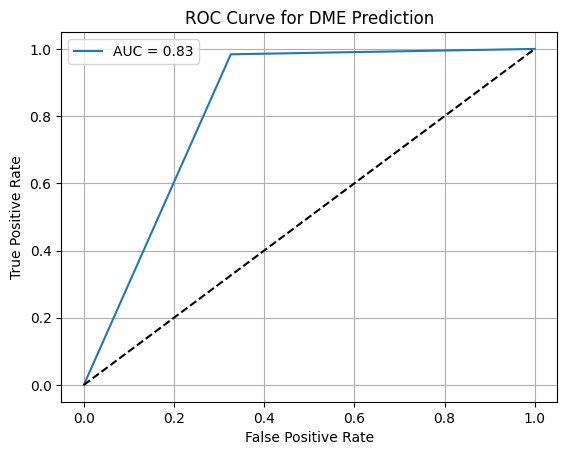

              precision    recall  f1-score   support

      No DME       0.98      0.67      0.80       500
         DME       0.75      0.98      0.85       500

    accuracy                           0.83      1000
   macro avg       0.86      0.83      0.82      1000
weighted avg       0.86      0.83      0.82      1000



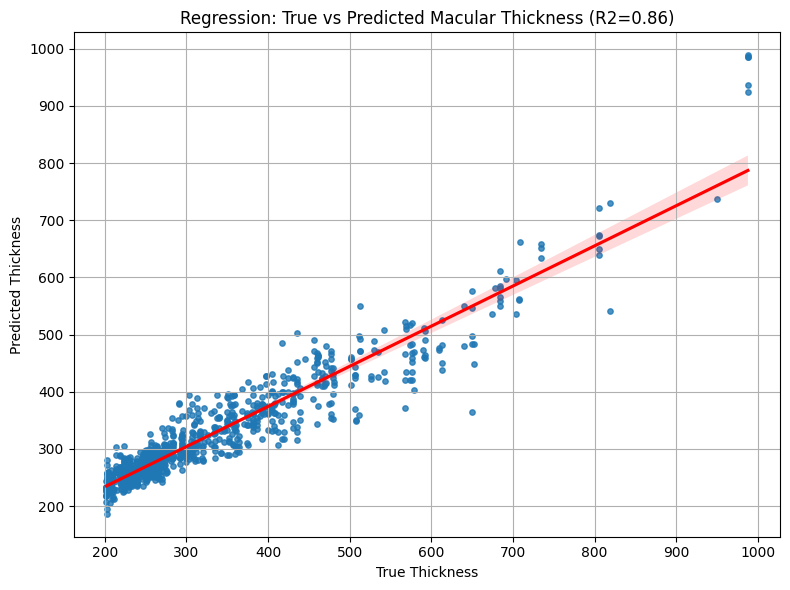

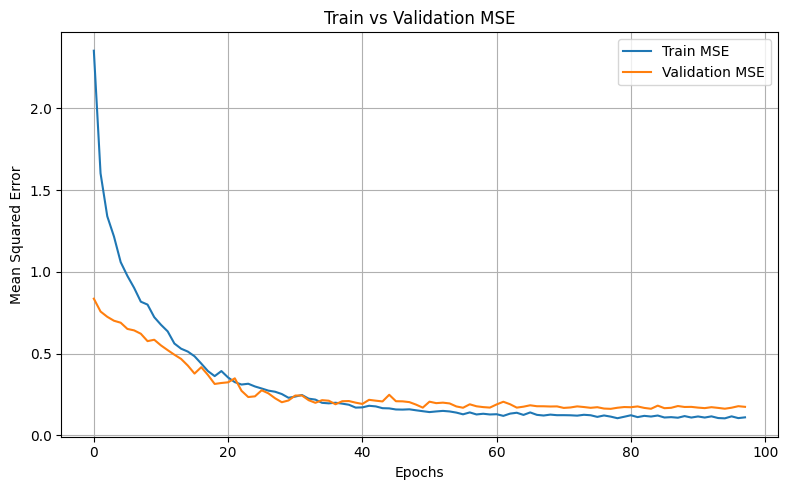

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# --- CONFIG ---
IMG_SIZE = 128
CSV_PATH = '/content/dme_patient_data.csv'
IMAGE_DIR = '/content/drive/MyDrive/DME APARNA/DME FUNDUS IMAGES AIMS_SABITHA HOS'

# --- 1. Load CSV ---
df = pd.read_csv(CSV_PATH)
df['filename'] = df['Patient'].astype(str) + '.png'

def resolve_image_path(pid):
    for ext in ['.png', '.jpg', '.jpeg']:
        path = os.path.join(IMAGE_DIR, pid + ext)
        if os.path.isfile(path):
            return path
    return None

df['filepath'] = df['Patient'].apply(resolve_image_path)
df = df.dropna(subset=['filepath'])

# --- 2. Preprocess Images ---
def preprocess_image(path):
    try:
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Could not read image: {path}")
            return None
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = densenet_preprocess(img.astype(np.float32))
        return img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# --- DR Stage Mapping ---
dr_stage_map = {
    'No DR': 0,
    'Mild NPDR': 1,
    'Moderate NPDR': 2,
    'Severe NPDR': 3,
    'PDR': 4
}

images, tabular, labels, dme_labels = [], [], [], []

for _, row in df.iterrows():
    img = preprocess_image(row['filepath'])
    if img is not None:
        images.append(img)
        tabular.append([
            row['VA'],
            row['DiabetesDuration'],
            1 if row['Neovascularization'] == 'Yes' else 0,
            row['HbA1c'],
            dr_stage_map.get(row['Stage of DR'], -1),
            1 if row['Presence of DME'] == 'Yes' else 0
        ])
        labels.append(row['Macular Thickness'])
        dme_labels.append(1 if row['Macular Thickness'] >= 270 else 0)

X_img = np.array(images)
X_tab = np.array(tabular)
y_raw = np.array(labels)
y_dme = np.array(dme_labels)

print(f"✅ Loaded {len(X_img)} images")

# --- 3. Balanced Augmentation to 5000 ---
target_per_class = 2500

X_img_dme = X_img[y_dme == 1]
X_tab_dme = X_tab[y_dme == 1]
y_dme_dme = y_raw[y_dme == 1]

X_img_nodme = X_img[y_dme == 0]
X_tab_nodme = X_tab[y_dme == 0]
y_dme_nodme = y_raw[y_dme == 0]

def augment_to_target(X_img_cls, X_tab_cls, y_cls, target_count):
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )

    aug_imgs, aug_tabs, aug_labs, aug_dmes = list(X_img_cls), list(X_tab_cls), list(y_cls), [1 if y >= 270 else 0 for y in y_cls]
    gen = datagen.flow(X_img_cls, y_cls, batch_size=32, shuffle=True)
    count = len(X_img_cls)

    while count < target_count:
        x_batch, y_batch = next(gen)
        take = min(len(x_batch), target_count - count)
        aug_imgs.extend(x_batch[:take])
        aug_tabs.extend(X_tab_cls[:take])
        aug_labs.extend(y_batch[:take])
        aug_dmes.extend([1 if y >= 270 else 0 for y in y_batch[:take]])
        count += take

    return np.array(aug_imgs), np.array(aug_tabs), np.array(aug_labs), np.array(aug_dmes)

X_img_dme_aug, X_tab_dme_aug, y_dme_aug, y_dme_bin_aug = augment_to_target(X_img_dme, X_tab_dme, y_dme_dme, target_per_class)
X_img_nodme_aug, X_tab_nodme_aug, y_nodme_aug, y_nodme_bin_aug = augment_to_target(X_img_nodme, X_tab_nodme, y_dme_nodme, target_per_class)

X_img_aug = np.concatenate([X_img_dme_aug, X_img_nodme_aug], axis=0)
X_tab_aug = np.concatenate([X_tab_dme_aug, X_tab_nodme_aug], axis=0)
y_all = np.concatenate([y_dme_aug, y_nodme_aug], axis=0)
y_dme_all = np.concatenate([y_dme_bin_aug, y_nodme_bin_aug], axis=0)

# --- 4. Normalize ---
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_aug)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_all.reshape(-1, 1)).flatten()

# --- 5. Split ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_img_aug, y_dme_all):
    X_img_train, X_img_test = X_img_aug[train_idx], X_img_aug[test_idx]
    X_tab_train, X_tab_test = X_tab_scaled[train_idx], X_tab_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    y_dme_train, y_dme_test = y_dme_all[train_idx], y_dme_all[test_idx]

# --- 6. Build DenseNet121 Model with Fine-Tuning and Dropout ---
def build_model(img_shape, tab_shape):
    img_input = Input(shape=img_shape)
    tab_input = Input(shape=tab_shape)

    base = DenseNet121(include_top=False, weights='imagenet', input_shape=img_shape)
    base.trainable = True

    # Fine-tune only last few layers
    for layer in base.layers[:-30]:
        layer.trainable = False

    x = base(img_input)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    merged = concatenate([x, tab_input])
    d1 = Dense(128, activation='relu')(merged)
    d1 = Dropout(0.4)(d1)
    d2 = Dense(64, activation='relu')(d1)
    d2 = Dropout(0.3)(d2)
    output = Dense(1)(d2)

    return Model(inputs=[img_input, tab_input], outputs=output)

model = build_model((IMG_SIZE, IMG_SIZE, 3), (X_tab.shape[1],))
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mse'])
model.summary()

# --- 7. Callbacks ---
checkpoint_path = '/content/best_densenet_model.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, min_delta=1e-4, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6, verbose=1)
]

# --- 8. Train ---
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --- 9. Evaluation ---
model.load_weights(checkpoint_path)
y_pred_scaled = model.predict([X_img_test, X_tab_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_true, y_pred)
print(f"Test R^2 Score: {r2:.4f}")

# --- 10. ROC for DME ---
dme_pred = (y_pred >= 270).astype(int)
unique_classes = np.unique(y_dme_test)
if len(unique_classes) < 2:
    print(f"⚠️ Only one class ({unique_classes[0]}) present in test labels. ROC and classification report are undefined.")
else:
    roc_auc = roc_auc_score(y_dme_test, dme_pred)
    fpr, tpr, _ = roc_curve(y_dme_test, dme_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for DME Prediction")
    plt.legend()
    plt.grid()
    plt.show()

    print(classification_report(y_dme_test, dme_pred, target_names=['No DME', 'DME']))

# --- 11. Scatter Plot ---
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), scatter_kws={'s': 15}, line_kws={'color': 'red'})
plt.xlabel('True Thickness')
plt.ylabel('Predicted Thickness')
plt.title(f'Regression: True vs Predicted Macular Thickness (R2={r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. MSE Plot ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


InceptionV3

✅ Loaded 320 images
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 2, 2,      │ 21,802,784 │ input_layer_6[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ inception_v3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 2054)      │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    263,040 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,082,337 (84.24 MB)

 Trainable params: 5,431,489 (20.72 MB)

 Non-trainable params: 16,650,848 (63.52 MB)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 6.0103 - mse: 6.0103
Epoch 1: val_loss improved from inf to 1.61205, saving model to /content/best_inception_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 266ms/step - loss: 5.9992 - mse: 5.9992 - val_loss: 1.6121 - val_mse: 1.6121 - learning_rate: 1.0000e-04
Epoch 2/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.2870 - mse: 3.2870
Epoch 2: val_loss improved from 1.61205 to 1.31984, saving model to /content/best_inception_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - loss: 3.2833 - mse: 3.2833 - val_loss: 1.3198 - val_mse: 1.3198 - learning_rate: 1.0000e-04
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.4535 - mse: 2.4535
Epoch 3: val_loss improved from 1.31984 to 0.85087, saving model to /content/best_inception_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 2.4535 - mse: 2.4535 - val_loss: 0.8509 - val_mse: 0.8509 - learning_rate: 1.0000e-04
Epoch 4/100
113/113 ━━━━━━━━━━━

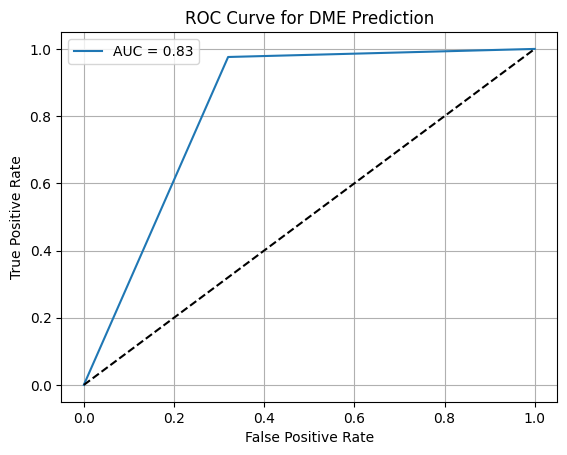

              precision    recall  f1-score   support

      No DME       0.97      0.68      0.80       500
         DME       0.75      0.98      0.85       500

    accuracy                           0.83      1000
   macro avg       0.86      0.83      0.82      1000
weighted avg       0.86      0.83      0.82      1000



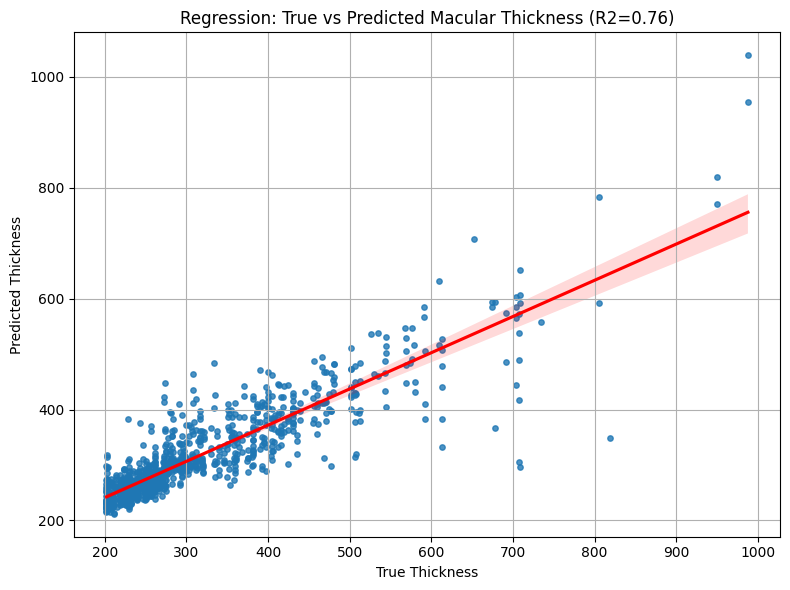

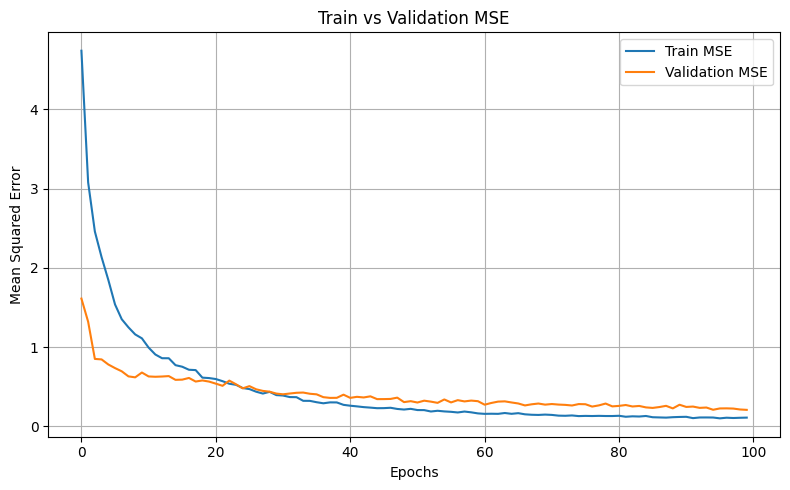

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

# --- CONFIG ---
IMG_SIZE = 128
CSV_PATH = '/content/dme_patient_data.csv'
IMAGE_DIR = '/content/drive/MyDrive/DME APARNA/DME FUNDUS IMAGES AIMS_SABITHA HOS'

# --- 1. Load CSV ---
df = pd.read_csv(CSV_PATH)
df['filename'] = df['Patient'].astype(str) + '.png'

def resolve_image_path(pid):
    for ext in ['.png', '.jpg', '.jpeg']:
        path = os.path.join(IMAGE_DIR, pid + ext)
        if os.path.isfile(path):
            return path
    return None

df['filepath'] = df['Patient'].apply(resolve_image_path)
df = df.dropna(subset=['filepath'])

# --- 2. Preprocess Images ---
def preprocess_image(path):
    try:
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Could not read image: {path}")
            return None
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = inception_preprocess(img.astype(np.float32))
        return img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# --- DR Stage Mapping ---
dr_stage_map = {
    'No DR': 0,
    'Mild NPDR': 1,
    'Moderate NPDR': 2,
    'Severe NPDR': 3,
    'PDR': 4
}

images, tabular, labels, dme_labels = [], [], [], []

for _, row in df.iterrows():
    img = preprocess_image(row['filepath'])
    if img is not None:
        images.append(img)
        tabular.append([
            row['VA'],
            row['DiabetesDuration'],
            1 if row['Neovascularization'] == 'Yes' else 0,
            row['HbA1c'],
            dr_stage_map.get(row['Stage of DR'], -1),
            1 if row['Presence of DME'] == 'Yes' else 0
        ])
        labels.append(row['Macular Thickness'])
        dme_labels.append(1 if row['Macular Thickness'] >= 270 else 0)

X_img = np.array(images)
X_tab = np.array(tabular)
y_raw = np.array(labels)
y_dme = np.array(dme_labels)

print(f"✅ Loaded {len(X_img)} images")

# --- 3. Balanced Augmentation to 5000 ---
target_per_class = 2500

X_img_dme = X_img[y_dme == 1]
X_tab_dme = X_tab[y_dme == 1]
y_dme_dme = y_raw[y_dme == 1]

X_img_nodme = X_img[y_dme == 0]
X_tab_nodme = X_tab[y_dme == 0]
y_dme_nodme = y_raw[y_dme == 0]

def augment_to_target(X_img_cls, X_tab_cls, y_cls, target_count):
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )

    aug_imgs, aug_tabs, aug_labs, aug_dmes = list(X_img_cls), list(X_tab_cls), list(y_cls), [1 if y >= 270 else 0 for y in y_cls]
    gen = datagen.flow(X_img_cls, y_cls, batch_size=32, shuffle=True)
    count = len(X_img_cls)

    while count < target_count:
        x_batch, y_batch = next(gen)
        take = min(len(x_batch), target_count - count)
        aug_imgs.extend(x_batch[:take])
        aug_tabs.extend(X_tab_cls[:take])
        aug_labs.extend(y_batch[:take])
        aug_dmes.extend([1 if y >= 270 else 0 for y in y_batch[:take]])
        count += take

    return np.array(aug_imgs), np.array(aug_tabs), np.array(aug_labs), np.array(aug_dmes)

X_img_dme_aug, X_tab_dme_aug, y_dme_aug, y_dme_bin_aug = augment_to_target(X_img_dme, X_tab_dme, y_dme_dme, target_per_class)
X_img_nodme_aug, X_tab_nodme_aug, y_nodme_aug, y_nodme_bin_aug = augment_to_target(X_img_nodme, X_tab_nodme, y_dme_nodme, target_per_class)

X_img_aug = np.concatenate([X_img_dme_aug, X_img_nodme_aug], axis=0)
X_tab_aug = np.concatenate([X_tab_dme_aug, X_tab_nodme_aug], axis=0)
y_all = np.concatenate([y_dme_aug, y_nodme_aug], axis=0)
y_dme_all = np.concatenate([y_dme_bin_aug, y_nodme_bin_aug], axis=0)

# --- 4. Normalize ---
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_aug)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_all.reshape(-1, 1)).flatten()

# --- 5. Split ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_img_aug, y_dme_all):
    X_img_train, X_img_test = X_img_aug[train_idx], X_img_aug[test_idx]
    X_tab_train, X_tab_test = X_tab_scaled[train_idx], X_tab_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    y_dme_train, y_dme_test = y_dme_all[train_idx], y_dme_all[test_idx]

# --- 6. Build InceptionV3 Model with Fine-Tuning and Dropout ---
def build_model(img_shape, tab_shape):
    img_input = Input(shape=img_shape)
    tab_input = Input(shape=tab_shape)

    base = InceptionV3(include_top=False, weights='imagenet', input_shape=img_shape)
    base.trainable = True

    for layer in base.layers[:-30]:
        layer.trainable = False

    x = base(img_input)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    merged = concatenate([x, tab_input])
    d1 = Dense(128, activation='relu')(merged)
    d1 = Dropout(0.4)(d1)
    d2 = Dense(64, activation='relu')(d1)
    d2 = Dropout(0.3)(d2)
    output = Dense(1)(d2)

    return Model(inputs=[img_input, tab_input], outputs=output)

model = build_model((IMG_SIZE, IMG_SIZE, 3), (X_tab.shape[1],))
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mse'])
model.summary()

# --- 7. Callbacks ---
checkpoint_path = '/content/best_inception_model.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, min_delta=1e-4, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6, verbose=1)
]

# --- 8. Train ---
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --- 9. Evaluation ---
model.load_weights(checkpoint_path)
y_pred_scaled = model.predict([X_img_test, X_tab_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_true, y_pred)
print(f"Test R^2 Score: {r2:.4f}")

# --- 10. ROC for DME ---
dme_pred = (y_pred >= 270).astype(int)
unique_classes = np.unique(y_dme_test)
if len(unique_classes) < 2:
    print(f"⚠️ Only one class ({unique_classes[0]}) present in test labels. ROC and classification report are undefined.")
else:
    roc_auc = roc_auc_score(y_dme_test, dme_pred)
    fpr, tpr, _ = roc_curve(y_dme_test, dme_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for DME Prediction")
    plt.legend()
    plt.grid()
    plt.show()

    print(classification_report(y_dme_test, dme_pred, target_names=['No DME', 'DME']))

# --- 11. Scatter Plot ---
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), scatter_kws={'s': 15}, line_kws={'color': 'red'})
plt.xlabel('True Thickness')
plt.ylabel('Predicted Thickness')
plt.title(f'Regression: True vs Predicted Macular Thickness (R2={r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. MSE Plot ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


GradeCam

✅ Using EfficientNet layer: block7a_project_conv

🔍 Grad-CAM for Test Image 1 (Index: 750)


/tmp/ipython-input-2574822177.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3] * 255


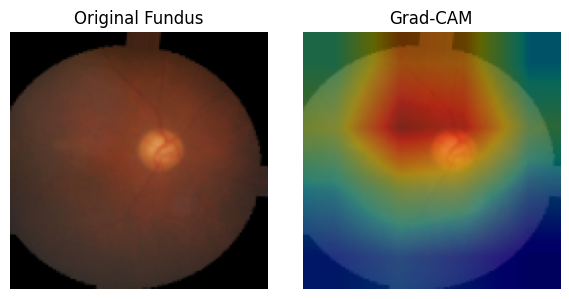


🔍 Grad-CAM for Test Image 2 (Index: 975)


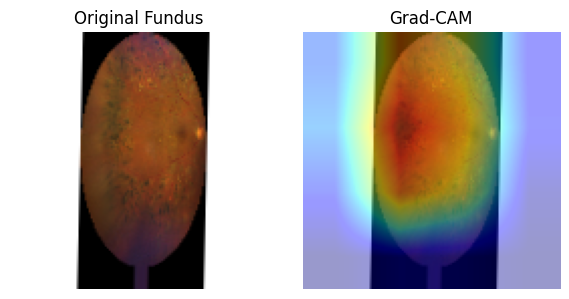


🔍 Grad-CAM for Test Image 3 (Index: 986)


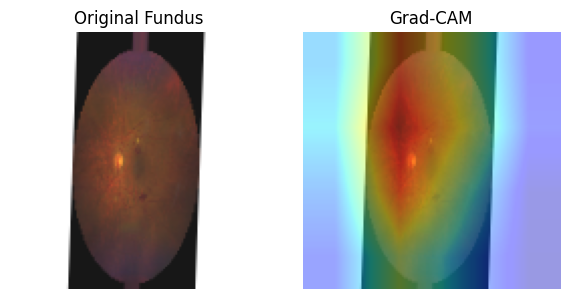


🔍 Grad-CAM for Test Image 4 (Index: 422)


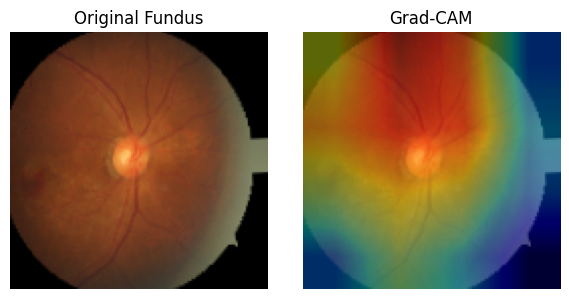

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
import random

# ✅ STEP 1: Find EfficientNet inside fusion model
def find_efficientnet_submodel(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and 'efficientnet' in layer.name.lower():
            return layer
    raise ValueError("EfficientNet submodel not found.")

# ✅ STEP 2: Generate Grad-CAM heatmap (no preprocessing)
def make_gradcam_heatmap(img_array, base_model, last_conv_layer_name):
    grad_model = Model(
        inputs=base_model.input,
        outputs=[
            base_model.get_layer(last_conv_layer_name).output,
            base_model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

# ✅ STEP 3: Overlay Grad-CAM heatmap on image
def display_gradcam(original_image, heatmap, alpha=0.4):
    image = original_image.astype(np.uint8)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3] * 255
    jet_heatmap = jet_colors[heatmap_resized.astype(int)]
    jet_heatmap = np.uint8(jet_heatmap)

    superimposed = cv2.addWeighted(image, 1 - alpha, jet_heatmap, alpha, 0)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Original Fundus")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.axis('off')
    plt.title("Grad-CAM")

    plt.tight_layout()
    plt.show()

# ✅ STEP 4: Run for 4 random test images
# Replace with your actual image size
IMG_SIZE = 128

# Assume you have: model (fusion model), X_img_test (raw images)

# Step A: Find EfficientNet submodel
base_model = find_efficientnet_submodel(model)
last_conv_layer_name = 'block7a_project_conv'
print(f"✅ Using EfficientNet layer: {last_conv_layer_name}")

# Step B: Pick 4 random indices
random_indices = random.sample(range(len(X_img_test)), 4)

# Step C: Generate and display Grad-CAM
for i, idx in enumerate(random_indices):
    print(f"\n🔍 Grad-CAM for Test Image {i+1} (Index: {idx})")
    raw_img = X_img_test[idx]
    img_input = np.expand_dims(raw_img, axis=0).astype(np.float32)  # no preprocessing

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_input, base_model, last_conv_layer_name)
    display_gradcam(raw_img, heatmap)


✅ Using EfficientNet layer: block7a_project_conv

🔍 Grad-CAM for Image 1: E194.jpg


/tmp/ipython-input-4286037659.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3] * 255


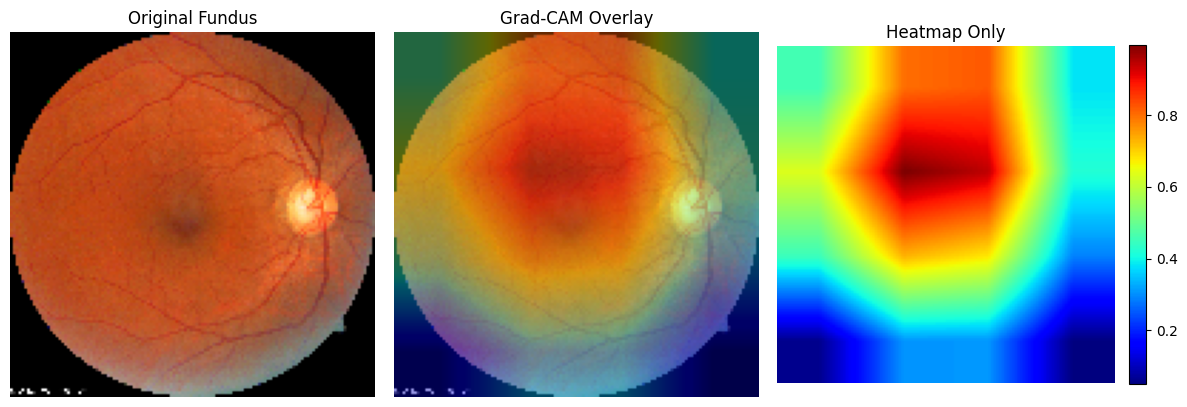

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
import os

# -------------------------
# 🔧 CONFIGURATION
# -------------------------

IMG_SIZE = 128  # or 224 based on your model

# ✅ Either a single image OR folder of images
image_input_path = "/content/drive/MyDrive/DME FUNDUS IMAGES AIMS_SABITHA HOS/E194.jpg"  # <-- your path

# -------------------------
# 🧠 MODEL UTILITIES
# -------------------------

def find_efficientnet_submodel(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and 'efficientnet' in layer.name.lower():
            return layer
    raise ValueError("EfficientNet submodel not found.")

def make_gradcam_heatmap(img_array, base_model, last_conv_layer_name):
    grad_model = Model(
        inputs=base_model.input,
        outputs=[
            base_model.get_layer(last_conv_layer_name).output,
            base_model.output
        ]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

def display_gradcam_full(original_image, heatmap, alpha=0.4):
    image = original_image.astype(np.uint8)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_scaled = np.uint8(255 * heatmap_resized)
    jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3] * 255
    jet_heatmap = jet_colors[heatmap_scaled]
    jet_heatmap = np.uint8(jet_heatmap)

    overlay = cv2.addWeighted(image, 1 - alpha, jet_heatmap, alpha, 0)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title("Original Fundus")

    axs[1].imshow(overlay)
    axs[1].axis('off')
    axs[1].set_title("Grad-CAM Overlay")

    im = axs[2].imshow(heatmap_resized, cmap='jet')
    axs[2].axis('off')
    axs[2].set_title("Heatmap Only")
    fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# -------------------------
# 🔁 RUN GRAD-CAM
# -------------------------

# ✅ Prepare list of image paths
if os.path.isdir(image_input_path):
    image_paths = [os.path.join(image_input_path, f) for f in os.listdir(image_input_path)
                   if f.endswith(('.jpg', '.png'))]
else:
    image_paths = [image_input_path]

# Ensure model is loaded
base_model = find_efficientnet_submodel(model)
last_conv_layer_name = 'block7a_project_conv'
print(f"✅ Using EfficientNet layer: {last_conv_layer_name}")

# Run Grad-CAM on each image
for i, img_path in enumerate(image_paths):
    print(f"\n🔍 Grad-CAM for Image {i+1}: {os.path.basename(img_path)}")

    raw_img = cv2.imread(img_path)
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    raw_img = cv2.resize(raw_img, (IMG_SIZE, IMG_SIZE))

    img_input = np.expand_dims(raw_img, axis=0).astype(np.float32)

    heatmap = make_gradcam_heatmap(img_input, base_model, last_conv_layer_name)
    display_gradcam_full(raw_img, heatmap)


✅ Using EfficientNet layer: block7a_project_conv

🔍 Grad-CAM for Image 1: E193.jpg


/tmp/ipython-input-4276977988.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3] * 255


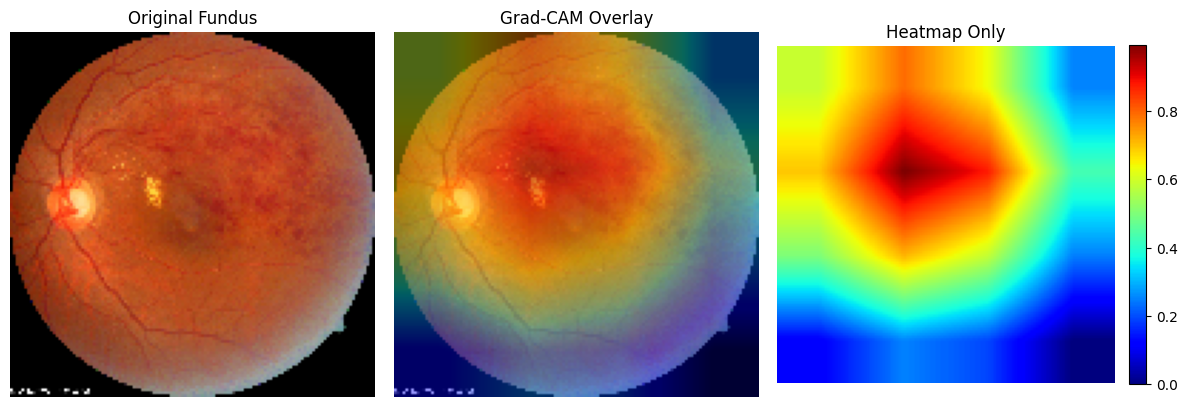

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
import os

# -------------------------
# 🔧 CONFIGURATION
# -------------------------

IMG_SIZE = 128  # or 224 based on your model

# ✅ Either a single image OR folder of images
image_input_path = "/content/drive/MyDrive/DME FUNDUS IMAGES AIMS_SABITHA HOS/E193.jpg"  # <-- your path

# -------------------------
# 🧠 MODEL UTILITIES
# -------------------------

def find_efficientnet_submodel(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and 'efficientnet' in layer.name.lower():
            return layer
    raise ValueError("EfficientNet submodel not found.")

def make_gradcam_heatmap(img_array, base_model, last_conv_layer_name):
    grad_model = Model(
        inputs=base_model.input,
        outputs=[
            base_model.get_layer(last_conv_layer_name).output,
            base_model.output
        ]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

def display_gradcam_full(original_image, heatmap, alpha=0.4):
    image = original_image.astype(np.uint8)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_scaled = np.uint8(255 * heatmap_resized)
    jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3] * 255
    jet_heatmap = jet_colors[heatmap_scaled]
    jet_heatmap = np.uint8(jet_heatmap)

    overlay = cv2.addWeighted(image, 1 - alpha, jet_heatmap, alpha, 0)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title("Original Fundus")

    axs[1].imshow(overlay)
    axs[1].axis('off')
    axs[1].set_title("Grad-CAM Overlay")

    im = axs[2].imshow(heatmap_resized, cmap='jet')
    axs[2].axis('off')
    axs[2].set_title("Heatmap Only")
    fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# -------------------------
# 🔁 RUN GRAD-CAM
# -------------------------

# ✅ Prepare list of image paths
if os.path.isdir(image_input_path):
    image_paths = [os.path.join(image_input_path, f) for f in os.listdir(image_input_path)
                   if f.endswith(('.jpg', '.png'))]
else:
    image_paths = [image_input_path]

# Ensure model is loaded
base_model = find_efficientnet_submodel(model)
last_conv_layer_name = 'block7a_project_conv'
print(f"✅ Using EfficientNet layer: {last_conv_layer_name}")

# Run Grad-CAM on each image
for i, img_path in enumerate(image_paths):
    print(f"\n🔍 Grad-CAM for Image {i+1}: {os.path.basename(img_path)}")

    raw_img = cv2.imread(img_path)
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    raw_img = cv2.resize(raw_img, (IMG_SIZE, IMG_SIZE))

    img_input = np.expand_dims(raw_img, axis=0).astype(np.float32)

    heatmap = make_gradcam_heatmap(img_input, base_model, last_conv_layer_name)
    display_gradcam_full(raw_img, heatmap)


Xception

✅ Loaded 320 images


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ input_layer_18[0… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1280)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 1286)      │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │    164,736 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      8,256 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │         65 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,227,748 (16.13 MB)

 Trainable params: 175,617 (686.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 201ms/step - loss: 1.5682 - mse: 1.5682 - val_loss: 0.6723 - val_mse: 0.6723 - learning_rate: 1.0000e-04
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.0029 - mse: 1.0029 - val_loss: 0.5818 - val_mse: 0.5818 - learning_rate: 1.0000e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8390 - mse: 0.8390 - val_loss: 0.5020 - val_mse: 0.5020 - learning_rate: 1.0000e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7236 - mse: 0.7236 - val_loss: 0.4563 - val_mse: 0.4563 - learning_rate: 1.0000e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.6204 - mse: 0.6204 - val_loss: 0.4276 - val_mse: 0.4276 - learning_rate: 1.0000e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5935 - mse: 0.5935 - val_loss: 0.3860 - val_mse: 0.3860 - learning_rate: 1.0000e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.5934 - mse: 0.5934 - val_loss: 0.3797 - val_mse: 0.37

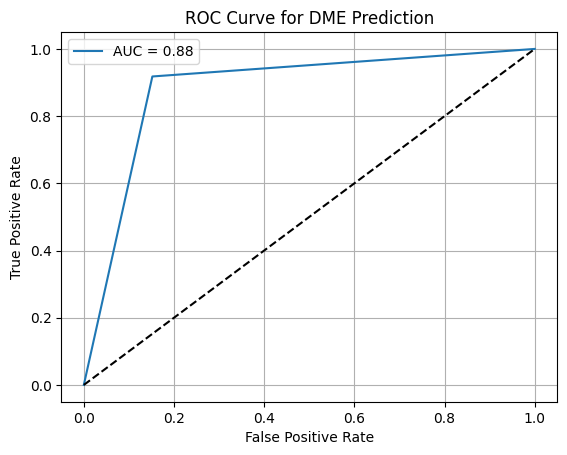

              precision    recall  f1-score   support

      No DME       0.91      0.85      0.88       500
         DME       0.86      0.92      0.89       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



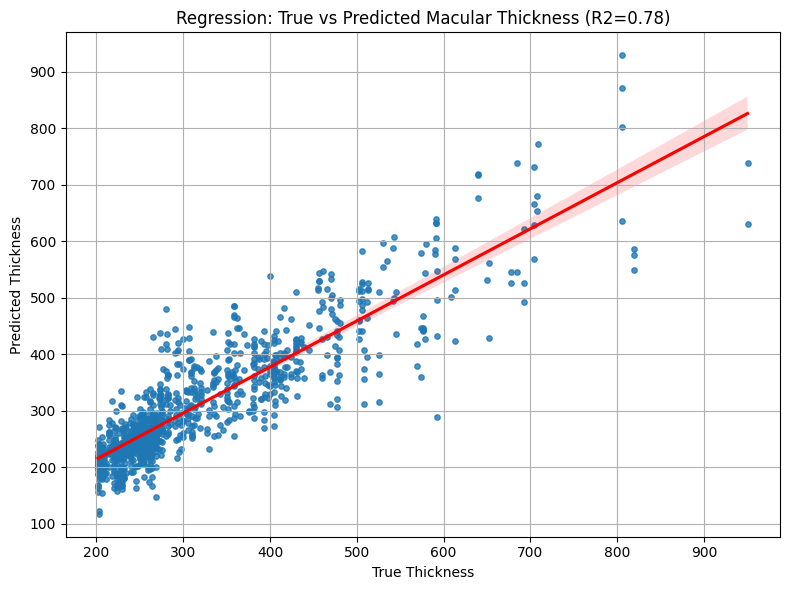

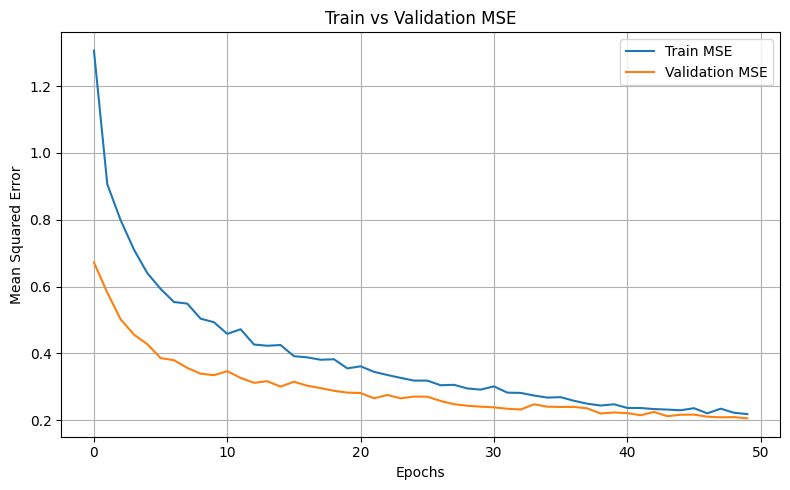

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

# --- CONFIG ---
IMG_SIZE = 128
CSV_PATH = '/content/dme_patient_data.csv'
IMAGE_DIR = '/content/drive/MyDrive/DME FUNDUS IMAGES AIMS_SABITHA HOS'

# --- 1. Load CSV ---
df = pd.read_csv(CSV_PATH)
df['filename'] = df['Patient'].astype(str) + '.png'

def resolve_image_path(pid):
    for ext in ['.png', '.jpg', '.jpeg']:
        path = os.path.join(IMAGE_DIR, pid + ext)
        if os.path.isfile(path):
            return path
    return None

df['filepath'] = df['Patient'].apply(resolve_image_path)
df = df.dropna(subset=['filepath'])

# --- 2. Preprocess Images ---
def preprocess_image(path):
    try:
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Could not read image: {path}")
            return None
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = xception_preprocess(img.astype(np.float32))
        return img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

images, tabular, labels, dme_labels = [], [], [], []

for _, row in df.iterrows():
    img = preprocess_image(row['filepath'])
    if img is not None:
        images.append(img)
        tabular.append([
            row['Age'], row['VA'], row['DiabetesDuration'],
            1 if row['Hypertension'] == 'Yes' else 0,
            row['IOP'], row['HbA1c']
        ])
        labels.append(row['Macular Thickness'])
        dme_labels.append(1 if row['Macular Thickness'] >= 270 else 0)

X_img = np.array(images)
X_tab = np.array(tabular)
y_raw = np.array(labels)
y_dme = np.array(dme_labels)

print(f"✅ Loaded {len(X_img)} images")

# --- 3. Balanced Augmentation to 5000 ---
target_per_class = 2500

X_img_dme = X_img[y_dme == 1]
X_tab_dme = X_tab[y_dme == 1]
y_dme_dme = y_raw[y_dme == 1]

X_img_nodme = X_img[y_dme == 0]
X_tab_nodme = X_tab[y_dme == 0]
y_dme_nodme = y_raw[y_dme == 0]

def augment_to_target(X_img_cls, X_tab_cls, y_cls, target_count):
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )

    aug_imgs, aug_tabs, aug_labs, aug_dmes = list(X_img_cls), list(X_tab_cls), list(y_cls), [1 if y >= 270 else 0 for y in y_cls]
    gen = datagen.flow(X_img_cls, y_cls, batch_size=32, shuffle=True)
    count = len(X_img_cls)

    while count < target_count:
        x_batch, y_batch = next(gen)
        take = min(len(x_batch), target_count - count)
        aug_imgs.extend(x_batch[:take])
        aug_tabs.extend(X_tab_cls[:take])
        aug_labs.extend(y_batch[:take])
        aug_dmes.extend([1 if y >= 270 else 0 for y in y_batch[:take]])
        count += take

    return np.array(aug_imgs), np.array(aug_tabs), np.array(aug_labs), np.array(aug_dmes)

X_img_dme_aug, X_tab_dme_aug, y_dme_aug, y_dme_bin_aug = augment_to_target(X_img_dme, X_tab_dme, y_dme_dme, target_per_class)
X_img_nodme_aug, X_tab_nodme_aug, y_nodme_aug, y_nodme_bin_aug = augment_to_target(X_img_nodme, X_tab_nodme, y_dme_nodme, target_per_class)

X_img_aug = np.concatenate([X_img_dme_aug, X_img_nodme_aug], axis=0)
X_tab_aug = np.concatenate([X_tab_dme_aug, X_tab_nodme_aug], axis=0)
y_all = np.concatenate([y_dme_aug, y_nodme_aug], axis=0)
y_dme_all = np.concatenate([y_dme_bin_aug, y_nodme_bin_aug], axis=0)

# --- 4. Normalize ---
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_aug)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_all.reshape(-1, 1)).flatten()

# --- 5. Split ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_img_aug, y_dme_all):
    X_img_train, X_img_test = X_img_aug[train_idx], X_img_aug[test_idx]
    X_tab_train, X_tab_test = X_tab_scaled[train_idx], X_tab_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    y_dme_train, y_dme_test = y_dme_all[train_idx], y_dme_all[test_idx]

# --- 6. Build Model (Xception) ---
def build_model(img_shape, tab_shape):
    img_input = Input(shape=img_shape)
    tab_input = Input(shape=tab_shape)

    base = Xception(include_top=False, weights='imagenet', input_shape=img_shape)
    base.trainable = False

    x = base(img_input)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    merged = concatenate([x, tab_input])
    d1 = Dense(128, activation='relu')(merged)
    d2 = Dense(64, activation='relu')(d1)
    output = Dense(1)(d2)

    return Model(inputs=[img_input, tab_input], outputs=output)

model = build_model((IMG_SIZE, IMG_SIZE, 3), (X_tab.shape[1],))
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mse'])
model.summary()

# --- 7. Callbacks ---
checkpoint_path = '/content/best_xception_model.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
]

# --- 8. Train ---
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --- 9. Evaluation ---
model.load_weights(checkpoint_path)
y_pred_scaled = model.predict([X_img_test, X_tab_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_true, y_pred)
print(f"Test R^2 Score: {r2:.4f}")

# --- 10. ROC for DME ---
dme_pred = (y_pred >= 270).astype(int)
unique_classes = np.unique(y_dme_test)
if len(unique_classes) < 2:
    print(f"⚠️ Only one class ({unique_classes[0]}) present in test labels. ROC and classification report are undefined.")
else:
    roc_auc = roc_auc_score(y_dme_test, dme_pred)
    fpr, tpr, _ = roc_curve(y_dme_test, dme_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for DME Prediction")
    plt.legend()
    plt.grid()
    plt.show()

    print(classification_report(y_dme_test, dme_pred, target_names=['No DME', 'DME']))

# --- 11. Scatter Plot ---
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), scatter_kws={'s': 15}, line_kws={'color': 'red'})
plt.xlabel('True Thickness')
plt.ylabel('Predicted Thickness')
plt.title(f'Regression: True vs Predicted Macular Thickness (R2={r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. MSE Plot ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


MobileNet

✅ Loaded 320 images
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_1.00_128  │ (None, 4, 4,      │  3,228,864 │ input_layer[0][0] │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ mobilenet_1.00_1… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1030)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    131,968 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,373,249 (12.87 MB)

 Trainable params: 142,337 (556.00 KB)

 Non-trainable params: 3,230,912 (12.32 MB)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5408 - mse: 1.5408
Epoch 1: val_loss improved from inf to 0.65866, saving model to /content/best_mobilenet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - loss: 1.5388 - mse: 1.5388 - val_loss: 0.6587 - val_mse: 0.6587 - learning_rate: 1.0000e-04
Epoch 2/100
110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9442 - mse: 0.9442
Epoch 2: val_loss improved from 0.65866 to 0.53806, saving model to /content/best_mobilenet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9421 - mse: 0.9421 - val_loss: 0.5381 - val_mse: 0.5381 - learning_rate: 1.0000e-04
Epoch 3/100
109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7694 - mse: 0.7694
Epoch 3: val_loss improved from 0.53806 to 0.48607, saving model to /content/best_mobilenet_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7679 - mse: 0.7679 - val_loss: 0.4861 - val_mse: 0.4861 - learning_rate: 1.0000e-04
Epoch 4/100
111/113 ━━━━━━━━━━━━━━

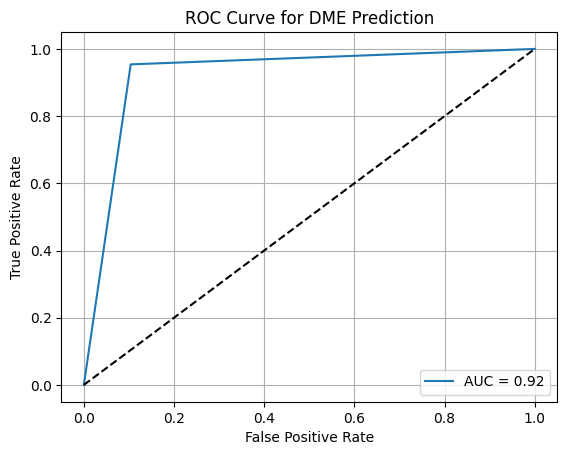

              precision    recall  f1-score   support

      No DME       0.95      0.90      0.92       500
         DME       0.90      0.95      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.93      0.93      0.92      1000



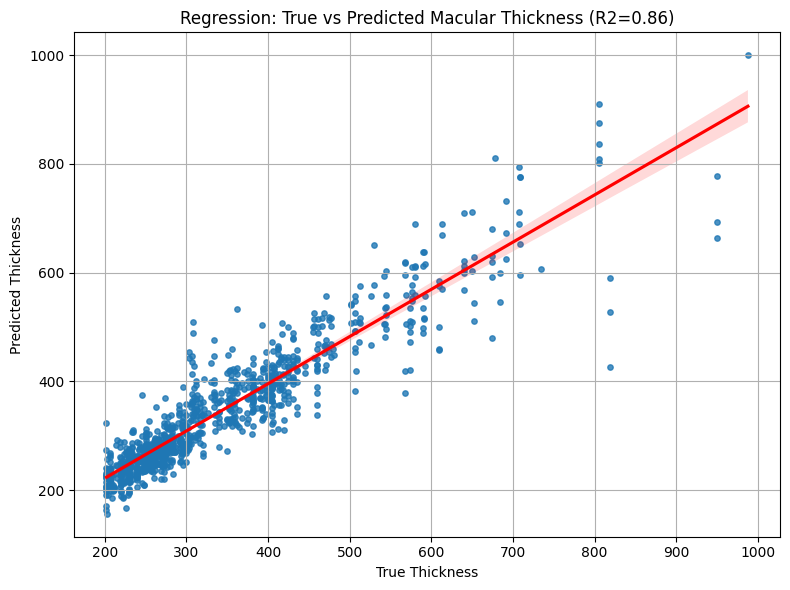

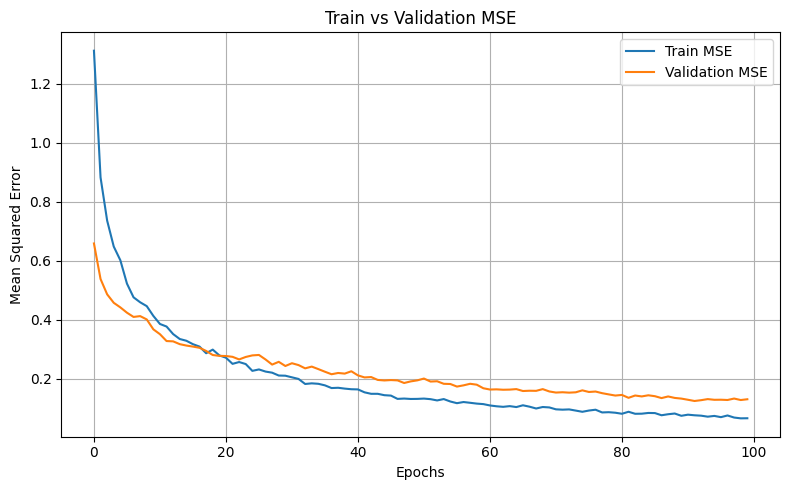

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# --- CONFIG ---
IMG_SIZE = 128
CSV_PATH = '/content/dme_patient_data.csv'
IMAGE_DIR = '/content/drive/MyDrive/Sabitha Eye Hospital and AIMS data/DME FUNDUS IMAGES AIMS_SABITHA HOS'

# --- 1. Load CSV ---
df = pd.read_csv(CSV_PATH)
df['filename'] = df['Patient'].astype(str) + '.png'

def resolve_image_path(pid):
    for ext in ['.png', '.jpg', '.jpeg']:
        path = os.path.join(IMAGE_DIR, pid + ext)
        if os.path.isfile(path):
            return path
    return None

df['filepath'] = df['Patient'].apply(resolve_image_path)
df = df.dropna(subset=['filepath'])

# --- 2. Preprocess Images ---
def preprocess_image(path):
    try:
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Could not read image: {path}")
            return None
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = mobilenet_preprocess(img.astype(np.float32))  # MobileNet preprocessing
        return img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# --- DR Stage Mapping ---
dr_stage_map = {
    'No DR': 0,
    'Mild NPDR': 1,
    'Moderate NPDR': 2,
    'Severe NPDR': 3,
    'PDR': 4
}

images, tabular, labels, dme_labels = [], [], [], []

for _, row in df.iterrows():
    img = preprocess_image(row['filepath'])
    if img is not None:
        images.append(img)
        tabular.append([
            row['VA'],
            row['DiabetesDuration'],
            1 if row['Neovascularization'] == 'Yes' else 0,
            row['HbA1c'],
            dr_stage_map.get(row['Stage of DR'], -1),
            1 if row['Presence of DME'] == 'Yes' else 0
        ])
        labels.append(row['Macular Thickness'])
        dme_labels.append(1 if row['Macular Thickness'] >= 300 else 0)

X_img = np.array(images)
X_tab = np.array(tabular)
y_raw = np.array(labels)
y_dme = np.array(dme_labels)

print(f"✅ Loaded {len(X_img)} images")

# --- 3. Balanced Augmentation to 5000 ---
target_per_class = 2500

X_img_dme = X_img[y_dme == 1]
X_tab_dme = X_tab[y_dme == 1]
y_dme_dme = y_raw[y_dme == 1]

X_img_nodme = X_img[y_dme == 0]
X_tab_nodme = X_tab[y_dme == 0]
y_dme_nodme = y_raw[y_dme == 0]

def augment_to_target(X_img_cls, X_tab_cls, y_cls, target_count):
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )

    aug_imgs, aug_tabs, aug_labs, aug_dmes = list(X_img_cls), list(X_tab_cls), list(y_cls), [1 if y >= 300 else 0 for y in y_cls]
    gen = datagen.flow(X_img_cls, y_cls, batch_size=32, shuffle=True)
    count = len(X_img_cls)

    while count < target_count:
        x_batch, y_batch = next(gen)
        take = min(len(x_batch), target_count - count)
        aug_imgs.extend(x_batch[:take])
        aug_tabs.extend(X_tab_cls[:take])
        aug_labs.extend(y_batch[:take])
        aug_dmes.extend([1 if y >= 300 else 0 for y in y_batch[:take]])
        count += take

    return np.array(aug_imgs), np.array(aug_tabs), np.array(aug_labs), np.array(aug_dmes)

X_img_dme_aug, X_tab_dme_aug, y_dme_aug, y_dme_bin_aug = augment_to_target(X_img_dme, X_tab_dme, y_dme_dme, target_per_class)
X_img_nodme_aug, X_tab_nodme_aug, y_nodme_aug, y_nodme_bin_aug = augment_to_target(X_img_nodme, X_tab_nodme, y_dme_nodme, target_per_class)

X_img_aug = np.concatenate([X_img_dme_aug, X_img_nodme_aug], axis=0)
X_tab_aug = np.concatenate([X_tab_dme_aug, X_tab_nodme_aug], axis=0)
y_all = np.concatenate([y_dme_aug, y_nodme_aug], axis=0)
y_dme_all = np.concatenate([y_dme_bin_aug, y_nodme_bin_aug], axis=0)

# --- 4. Normalize ---
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_aug)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_all.reshape(-1, 1)).flatten()

# --- 5. Split ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_img_aug, y_dme_all):
    X_img_train, X_img_test = X_img_aug[train_idx], X_img_aug[test_idx]
    X_tab_train, X_tab_test = X_tab_scaled[train_idx], X_tab_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    y_dme_train, y_dme_test = y_dme_all[train_idx], y_dme_all[test_idx]

# --- 6. Build Model ---
def build_model(img_shape, tab_shape):
    img_input = Input(shape=img_shape)
    tab_input = Input(shape=tab_shape)

    base = MobileNet(
        include_top=False,
        weights='imagenet',
        input_shape=img_shape
    )
    base.trainable = False

    x = base(img_input)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    merged = concatenate([x, tab_input])
    d1 = Dense(128, activation='relu')(merged)
    d2 = Dense(64, activation='relu')(d1)
    output = Dense(1)(d2)

    return Model(inputs=[img_input, tab_input], outputs=output)

model = build_model((IMG_SIZE, IMG_SIZE, 3), (X_tab.shape[1],))
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mse'])
model.summary()

# --- 7. Callbacks ---
checkpoint_path = '/content/best_mobilenet_model.keras'
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        min_delta=1e-4,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=10,
        factor=0.5,
        min_lr=1e-6,
        verbose=1
    )
]

# --- 8. Train ---
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --- 9. Evaluation ---
model.load_weights(checkpoint_path)
y_pred_scaled = model.predict([X_img_test, X_tab_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_true, y_pred)
print(f"Test R^2 Score: {r2:.4f}")

# --- 10. ROC for DME ---
dme_pred = (y_pred >= 300).astype(int)
unique_classes = np.unique(y_dme_test)
if len(unique_classes) < 2:
    print(f"⚠️ Only one class ({unique_classes[0]}) present in test labels. ROC and classification report are undefined.")
else:
    roc_auc = roc_auc_score(y_dme_test, dme_pred)
    fpr, tpr, _ = roc_curve(y_dme_test, dme_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for DME Prediction")
    plt.legend()
    plt.grid()
    plt.show()

    print(classification_report(y_dme_test, dme_pred, target_names=['No DME', 'DME']))

# --- 11. Scatter Plot ---
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), scatter_kws={'s': 15}, line_kws={'color': 'red'})
plt.xlabel('True Thickness')
plt.ylabel('Predicted Thickness')
plt.title(f'Regression: True vs Predicted Macular Thickness (R2={r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. MSE Plot ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Feature selection Random forest _Boruta


In [ ]:
pip install boruta scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from boruta import BorutaPy

# --- 1. Load Data ---
csv_path = '/content/dme_patient_data.csv'
df = pd.read_csv(csv_path)

# --- 2. Clean & Encode ---
df = df.dropna(subset=['Macular Thickness'])

# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col not in ['Patient']:  # exclude Patient ID
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# --- 3. Define Features and Target ---
exclude_cols = ['Patient', 'Macular Thickness']  # ignore ID and target
X = df.drop(columns=exclude_cols)
y = df['Macular Thickness'].values

# --- 4. Standardize (Optional but Recommended) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 5. Boruta Feature Selection ---
forest = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=42)
boruta = BorutaPy(estimator=forest, n_estimators='auto', verbose=1, random_state=42)
boruta.fit(X_scaled, y)

# --- 6. Selected Features ---
selected = X.columns[boruta.support_].tolist()
print("✅ Selected Features by Boruta:")
for feature in selected:
    print("-", feature)

# Optional: Reduced dataframe
df_selected = df[selected + ['Macular Thickness']]


Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	4
✅ Selected Features by Boruta:
- VA
- DiabetesDuration
- Neovascularization
- HbA1c
- Stage of DR
- Presence of DME


In [ ]:
from PIL import Image

# Load the image
input_path = "/content/Capture 2.JPG"  # Change to your input image file
output_path = "output_image_400dpi.tiff"

# Open the image
img = Image.open(input_path)

# Save as TIFF with 400 DPI
img.save(output_path, format='TIFF', dpi=(400, 400))

print("✅ Image saved as high-quality TIFF with 400 DPI")


✅ Image saved as high-quality TIFF with 400 DPI
